In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
from jax import grad, vmap, jit, jacfwd, jacrev
from functools import partial
from jax.flatten_util import ravel_pytree
import jax.random as random
from jax.lax import cond, scan
import jax.example_libraries.optimizers as optimizers
key = random.PRNGKey(2022)

from utils_node import init_params_damage
from utils_node import RK_forward_pass_nobias as NODE_nobias, RK_forward_pass as NODE

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import pickle


from diffrax import diffeqsolve, ODETerm, SaveAt#, Heun as mysolver
from diffrax import Dopri5 as mysolver
from diffrax import Heun as mysolver

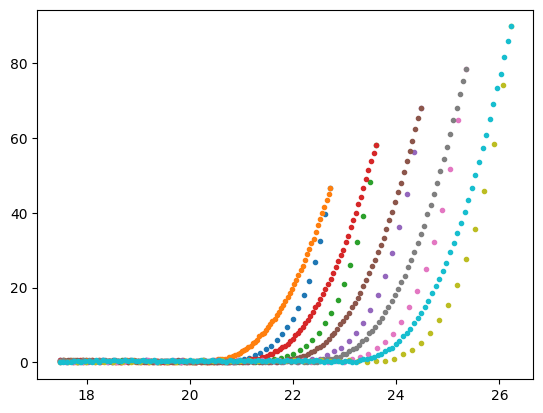

In [2]:
specimen = 'PA_Belly_Dermis1'

metadata = pd.read_csv('data/Dermis/DamageData.csv')
width = float(metadata[metadata.Specimen == specimen]['Width'])
thickness = float(metadata[metadata.Specimen == specimen]['Thickness'])
A = width*thickness # Cross sectional area


data = pd.read_csv('data/Dermis/DamageData/' + specimen + 'Data.csv')
def extract_numbers_and_cycle(value):
    parts = value.split('-')
    number = int(parts[0])
    cycle = parts[1] if len(parts) > 1 else None
    return pd.Series({'#': number, 'Cycle': cycle})

#Extract the unloaded length so we can find the stretches
data2 = data[data.Cycle != '1-Preload']
L0 = np.min(data2['Size_mm'])


"""
Currently the data has a column similar to 2-Recover, where the "2" indicates
the cycle number and "Recover" the stage of loading within that cycle. 
Change this so that the column "Cycle" only contains the cycle number, say, "2"
and add a new column called "Type" that contains the stage of loading.
"""
data[['#', 'Cycle']] = data['Cycle'].apply(extract_numbers_and_cycle)
data = data[['SetName', '#', 'Cycle', 'Time_S', 'Size_mm', 'Displacement_mm', 'Force_N']]
data = data.rename(columns={'Cycle': 'Type', '#': 'Cycle'})


"""
The specimen is loaded to each lmb_max 5 times. In theory all the curves after 
the first should overlap, since the maximum amount of deformation hasn't 
increased. But the stress curves still keep decreasing. Our current formulation
of damage cannot account for this, so only keep the last cycle.
"""
data = data[data.Cycle==5]
data = data.groupby(['SetName', 'Type'])
for d in data:
    plt.plot(d[1]['Size_mm'], d[1]['Force_N'], '.')

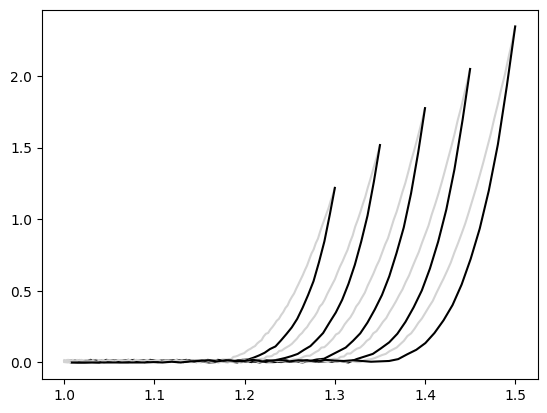

In [3]:
specimen = 'PA_Belly_Dermis1'

metadata = pd.read_csv('data/Dermis/DamageData.csv')
width = float(metadata[metadata.Specimen == specimen]['Width'])
thickness = float(metadata[metadata.Specimen == specimen]['Thickness'])
A = width*thickness # Cross sectional area


data = pd.read_csv('data/Dermis/DamageData/' + specimen + 'Data.csv')
def extract_numbers_and_cycle(value):
    parts = value.split('-')
    number = int(parts[0])
    cycle = parts[1] if len(parts) > 1 else None
    return pd.Series({'#': number, 'Cycle': cycle})

#Extract the unloaded length so we can find the stretches
data2 = data[data.Cycle != '1-Preload']
L0 = np.min(data2['Size_mm'])


"""
Currently the data has a column similar to 2-Recover, where the "2" indicates
the cycle number and "Recover" the stage of loading within that cycle. 
Change this so that the column "Cycle" only contains the cycle number, say, "2"
and add a new column called "Type" that contains the stage of loading.
"""
data[['#', 'Cycle']] = data['Cycle'].apply(extract_numbers_and_cycle)
data = data[['SetName', '#', 'Cycle', 'Time_S', 'Size_mm', 'Displacement_mm', 'Force_N']]
data = data.rename(columns={'Cycle': 'Type', '#': 'Cycle'})


"""
The specimen is loaded to each lmb_max 5 times. In theory all the curves after 
the first should overlap, since the maximum amount of deformation hasn't 
increased. But the stress curves still keep decreasing. Our current formulation
of damage cannot account for this, so only keep the last cycle.
"""
data = data[data.Cycle==5]
setnames = np.unique(data['SetName'])
data_l = data[data.Type == 'Stretch']
l = np.min([len(data_l[data_l['SetName']==setname]) for setname in setnames])
# Collect the relevant variables in numpy arrays
time_l_gt = []
disp_l_gt = []
sgmx_l_gt = []
for setname in setnames:
    time_l_gt.append(data_l[data_l['SetName']==setname]['Time_S'][:l])
    disp_l_gt.append(data_l[data_l['SetName']==setname]['Displacement_mm'][:l])
    sgmx_l_gt.append(data_l[data_l['SetName']==setname]['Force_N'][:l]/A)
time_l_gt = np.array(time_l_gt)
disp_l_gt = np.array(disp_l_gt)
sgmx_l_gt = np.array(sgmx_l_gt)
lmbx_l_gt = 1.0+disp_l_gt/L0



data_u = data[data.Type == 'Recover']
l = np.min([len(data_u[data_u['SetName']==setname]) for setname in setnames]) #get the minimum length of data_u so we have a common length
# Collect the relevant variables in numpy arrays
time_u_gt = []
disp_u_gt = []
sgmx_u_gt = []
for setname in setnames:
    time_u_gt.append(data_u[data_u['SetName']==setname]['Time_S'][:l])
    disp_u_gt.append(np.flip(data_u[data_u['SetName']==setname]['Displacement_mm'][:l]))
    sgmx_u_gt.append(np.flip(data_u[data_u['SetName']==setname]['Force_N'][:l]/A))
time_u_gt = np.array(time_u_gt)
disp_u_gt = np.array(disp_u_gt)
sgmx_u_gt = np.array(sgmx_u_gt)
lmbx_u_gt = 1.0+disp_u_gt/L0


# # Get rid of the jumps in time
# t0 = 0.0
# for i in range(len(time_u_gt)):
#     time_u_gt[i] = time_u_gt[i] - time_u_gt[i][0] + t0
#     t0 = time_u_gt[i][-1]


n_cycles = len(time_u_gt)
for i in range(n_cycles):
    plt.plot(lmbx_l_gt[i], sgmx_l_gt[i], 'lightgray')
    plt.plot(lmbx_u_gt[i], sgmx_u_gt[i], 'k-')

n_damage = 4

In [4]:
#Psi functions
def Psi1_fn(params, I1):
    params, bias = params
    return NODE_nobias(I1-3, params) + jnp.exp(bias)
def Psi2_fn(params, I2):
    params, bias = params
    return NODE_nobias(I2-3, params) + jnp.exp(bias)
def Psiv_fn(params, Iv):
    params, theta = params
    Psiv = NODE_nobias(Iv-1, params)
    return jnp.maximum(Psiv, 0.0)
def Psiw_fn(params, Iw):
    params, theta = params
    Psiw = NODE_nobias(Iw-1, params)
    return jnp.maximum(Psiw, 0.0)
Psi_fns = (Psi1_fn, Psi2_fn, Psiv_fn, Psiw_fn)

def f(d, params):
    return 1.0-d
f_vmap = vmap(f, in_axes=(0, None))
def G(tau, params):
    return NODE(tau, params)
G_vmap = vmap(G, in_axes=(0, None))

In [5]:
def eval_Cauchy(lmbx, lmby, d, params):
    params_Psi_list, params_f_list, params_G_list = params
    params_1, params_2, params_v, params_w = params_Psi_list

    lmbz = 1.0/(lmbx*lmby)
    F = jnp.array([[lmbx, 0, 0],
                   [0, lmby, 0],
                   [0, 0, lmbz]])
    C = F.T @ F
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    theta_v = params_v[1]
    theta_w = params_w[1]
    v0 = jnp.array([jnp.sin(theta_v), jnp.cos(theta_v), 0])
    w0 = jnp.array([jnp.sin(theta_w), jnp.cos(theta_w), 0])
    V0 = jnp.outer(v0, v0)
    W0 = jnp.outer(w0, w0)

    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    Iv = jnp.einsum('ij,ij',C,V0)
    Iw = jnp.einsum('ij,ij',C,W0)

    f1 = f(d[0], params_f_list[0])
    f2 = f(d[1], params_f_list[1])
    f3 = f(d[2], params_f_list[2])
    f4 = f(d[3], params_f_list[3])
    Psi1 = jnp.maximum(f1,0.0)*Psi1_fn(params_1, I1)
    Psi2 = jnp.maximum(f2,0.0)*Psi2_fn(params_2, I2)
    Psiv = jnp.maximum(f3,0.0)*Psiv_fn(params_v, Iv)
    Psiw = jnp.maximum(f4,0.0)*Psiw_fn(params_w, Iw)

    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2] + 2*Psiw*W0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0 + 2*Psiw*W0

    sgm = F @ (S @ F.T)
    return sgm
eval_Cauchy_vmap = vmap(eval_Cauchy, in_axes=(0,0,0,None), out_axes = 0)
eval_Cauchy_vmap2 = vmap(eval_Cauchy, in_axes=(0,0,None,None), out_axes = 0)

In [6]:
@jit
def ddot_fn(params, y, Psidot_list):
    params_Psi_list, params_f_list, params_G_list = params
    ddot_list = []
    rdot_list = []
    taudot_list = []
    for i in range(n_damage):
        Psi0dot     = Psidot_list[i] #keep in mind that tau = Psi0dot
        di          = y[i]
        ri          = y[n_damage+i]
        Psi0        = y[2*n_damage+i]
        params_f    = params_f_list[i]
        params_G    = params_G_list[i]

        dfdd = grad(f)(di, params_f)
        taui = -Psi0*dfdd

        #check if g<0
        g = G(taui, params_G) - G(ri, params_G)
        def true_fun(): #What to return for rdot & ddot if g<0
            return 0.0, 0.0, Psi0dot
        def false_fun():
            dGdtau = grad(G)(taui, params_G)
            d2fdd2 = grad(grad(f))(di, params_f)
            ddot = -(Psi0dot*dfdd*dGdtau)/(1+Psi0*d2fdd2*dGdtau)
            rdot = -Psi0dot*dfdd - Psi0*dfdd*ddot
            return ddot, rdot, Psi0dot
        ddot, rdot, taudot = cond(g<0, true_fun, false_fun)
        ddot_list.append(ddot)
        rdot_list.append(rdot)
        taudot_list.append(taudot)
    return jnp.array(ddot_list + rdot_list + taudot_list)

def Psii_uniaxial(t, params_Psi_list, lmb_dot, theta_v, theta_w):
    lmbx = 1.0 + lmb_dot*t
    # lmby = lmbz = 1.0/jnp.sqrt(lmbx)
    I1 = lmbx**2 + 2.0/lmbx # = lmbx**2 + lmby**2 + lmbz**2
    I2 = 2*lmbx + 1.0/lmbx**2 # = lmbx**2*lmby**2 + lmbx**2*lmbz**2 + lmby**2*lmbz**2
    Iv = lmbx**2*jnp.sin(theta_v)**2 + 1.0/lmbx*jnp.cos(theta_v)**2 # = lmbx**2*jnp.sin(theta_v)**2 + lmby**2*jnp.cos(theta_v)**2
    Iw = lmbx**2*jnp.sin(theta_w)**2 + 1.0/lmbx*jnp.cos(theta_w)**2 # = lmbx**2*jnp.sin(theta_w)**2 + lmby**2*jnp.cos(theta_w)**2
    I = [I1, I2, Iv, Iw]
    Psi0 = []
    for i in range(n_damage):
        params  = params_Psi_list[i]
        Psi_fn  = Psi_fns[i]
        Ii      = I[i]
        Psi0.append(Psi_fn(params, Ii))
    return Psi0

@jit
def integrate_d_uniax(params, lmb_max, y0):
    theta_v = params[0][2][1]
    theta_w = params[0][3][1]
    
    t_peak = 1.0
    lmb_dot = (lmb_max-1.0)/t_peak
    def yprime(t, y, args=None):
        Psidot = jacfwd(Psii_uniaxial)(t, params[0], lmb_dot, theta_v, theta_w)
        return ddot_fn(params, y, Psidot)
    # y = odeint(yprime, y0, t=jnp.linspace(0.0,1.0))
    term = ODETerm(yprime)
    solver = mysolver()
    saveat = SaveAt(ts=jnp.linspace(0.0,1.0))
    solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.001, y0=y0, saveat=saveat)
    return solution.ys


In [7]:
@jit
def repeat_uniax(params, lmbx):
    bias1 = params[0][0][1]
    bias2 = params[0][1][1]
    y0 = jnp.array([0.0,0.0,0.0,0.0,jnp.exp(bias1),jnp.exp(bias2),0.0,0.0,jnp.exp(bias1),jnp.exp(bias2),0.0,0.0])
    d = [] 
    for i in range(n_cycles):
        lmb_max = jnp.max(lmbx[i])
        y = integrate_d_uniax(params, lmb_max, y0)
        d.append(y)
        y0 = y[-1]
        y0 = y0.at[8].set(jnp.exp(bias1))
        y0 = y0.at[9].set(jnp.exp(bias2))
        y0 = y0.at[10].set(jnp.float64(0.0))
        y0 = y0.at[11].set(jnp.float64(0.0))
    return jnp.array(d)

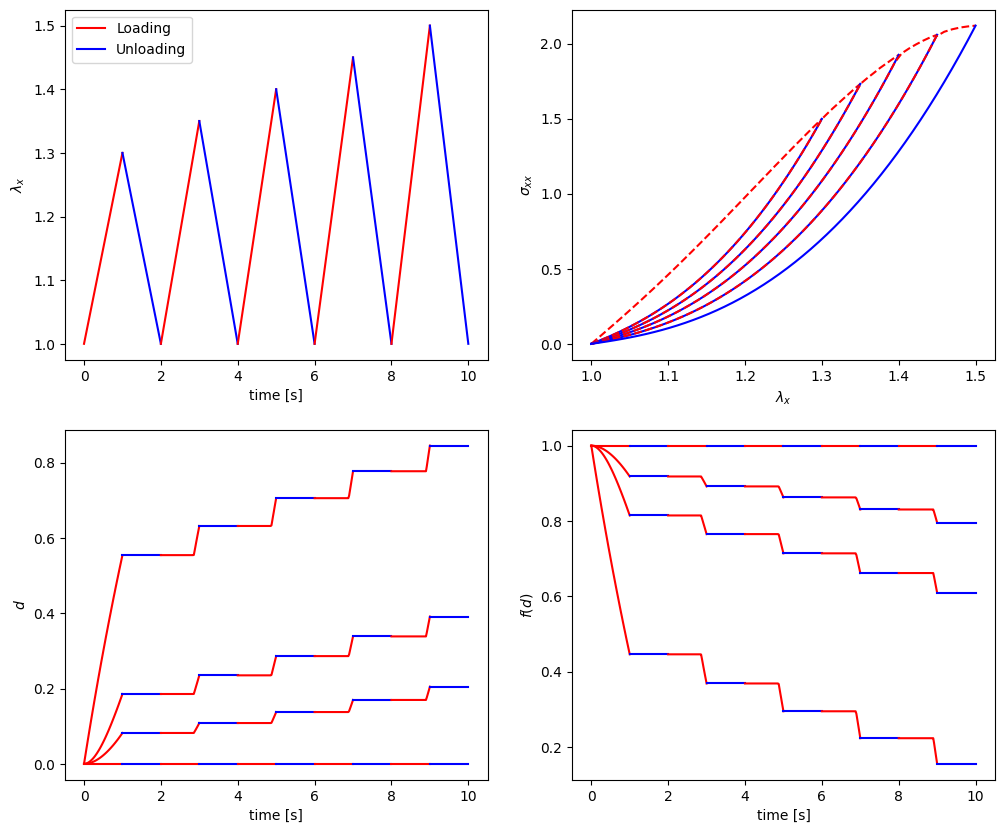

In [8]:
params = init_params_damage(key)
f_params = params[1]
d = repeat_uniax(params, lmbx_u_gt)
d = np.array(d)
d[:,:,:4] = np.clip(d[:,:,:4], a_min=0.0, a_max=1.0)

fig, ax = plt.subplots(2,2,figsize=(12,10))
t0 = 0.0
for i in range(n_cycles):
    lmb_max = np.max(lmbx_l_gt[i])
    n = len(d[i])
    lmbx = np.linspace(1.0, lmb_max, n)
    lmby = 1.0/np.sqrt(lmbx)

    time = np.linspace(t0, t0+1.0, n)
    sgmx_l_pr = eval_Cauchy_vmap(lmbx, lmby, d[i], params)
    sgmx_u_pr = eval_Cauchy_vmap2(lmbx, lmby, d[i][-1], params)

    for j in range(n_damage):
        # Loading
        f_vals = f_vmap(d[i,:,j], f_params[j])
        ax[1,0].plot(time, d[i,:,j], 'r-')
        ax[1,1].plot(time, f_vals,   'r-')

        # Unloading
        ax[1,0].plot(time+1.0, np.repeat(d[i,-1,j],  n), 'b-')
        ax[1,1].plot(time+1.0, np.repeat(f_vals[-1], n), 'b-')

    ax[0,0].plot(time, lmbx, 'r-')
    ax[0,1].plot(lmbx, sgmx_l_pr[:,0,0], 'r--', label='Loading')

    ax[0,0].plot(time+1.0, np.flip(lmbx), 'b-')
    ax[0,1].plot(lmbx, sgmx_u_pr[:,0,0], 'b-', label='Unloading')

    t0 += 2
ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')
ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

legend_elements = [Line2D([0], [0], color='r', label='Loading'),
                   Line2D([0], [0], color='b', label='Unloading')]
ax[0,0].legend(handles=legend_elements)

# Set up training

In [9]:
def loss(params, lmbx_u_gt, sgmx_u_gt):
    d = repeat_uniax(params, lmbx_u_gt)
    loss = []
    for i in range(5):
        di = d[i]
        lmbx = lmbx_u_gt[i]
        lmby = 1.0/jnp.sqrt(lmbx)
        sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di[-1], params)[:,0,0]
        loss.append((sgmx_u_gt-sgmx_pr)**2)
    return jnp.mean(jnp.array(loss))

@partial(jit, static_argnums=(0,2,3,))
def step(loss, i, get_params, opt_update, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000, metric_fns=None, batch_size=None):
    train_loss = []
    metrics = []
    for it in range(nIter):
        key, subkey = random.split(key)
        if batch_size is None:
            X_batch = X
            Y_batch = Y
        else:
            idx = random.choice(key=key, a=jnp.arange(len(X)), shape=(batch_size,), replace=False)
            X_batch = X[idx]
            Y_batch = Y[idx]
        opt_state = step(loss, it, get_params, opt_update, opt_state, X_batch, Y_batch)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            if metric_fns is not None:
                m = []
                for metric_fn in metric_fns:
                    m.append(metric_fn(params, X, Y))
                metrics.append(m)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, metrics

In [10]:
params = init_params_damage(key, Psi_layers=[1,5,5,5,1], f_layers=[1,5,5,5,1], G_layers=[1,5,5,5,1])
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params)

# Train
inp = lmbx_u_gt
out = sgmx_u_gt
params, train_loss, _ = train(loss, inp, sgmx_u_gt, get_params, opt_update, opt_state, key, nIter = 20000, print_freq=1000)

it 1000, train loss = 4.171304e-02
it 2000, train loss = 3.170300e-02
it 3000, train loss = 2.929221e-02
it 4000, train loss = 2.646873e-02
it 5000, train loss = 2.454366e-02
it 6000, train loss = 2.330684e-02
it 7000, train loss = 2.231662e-02
it 8000, train loss = 2.160760e-02
it 9000, train loss = 2.110601e-02
it 10000, train loss = 2.063920e-02
it 11000, train loss = 2.029413e-02
it 12000, train loss = 1.999646e-02
it 13000, train loss = 1.971039e-02
it 14000, train loss = 1.946462e-02
it 15000, train loss = 1.926135e-02
it 16000, train loss = 1.923239e-02
it 17000, train loss = 1.905497e-02
it 18000, train loss = 1.898026e-02
it 19000, train loss = 1.888457e-02
it 20000, train loss = 1.875700e-02


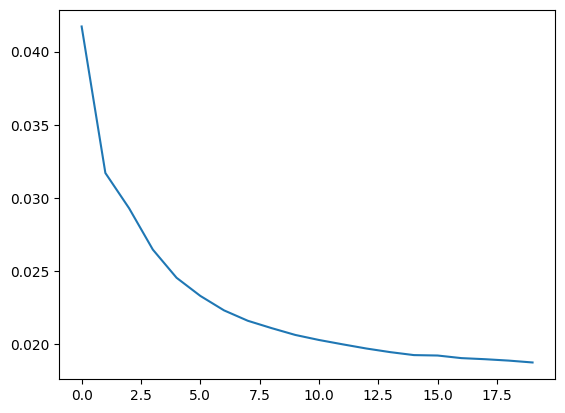

In [11]:
plt.plot(train_loss)

[Text(0.5, 0, 'time [s]'), Text(0, 0.5, '$f(d)$')]

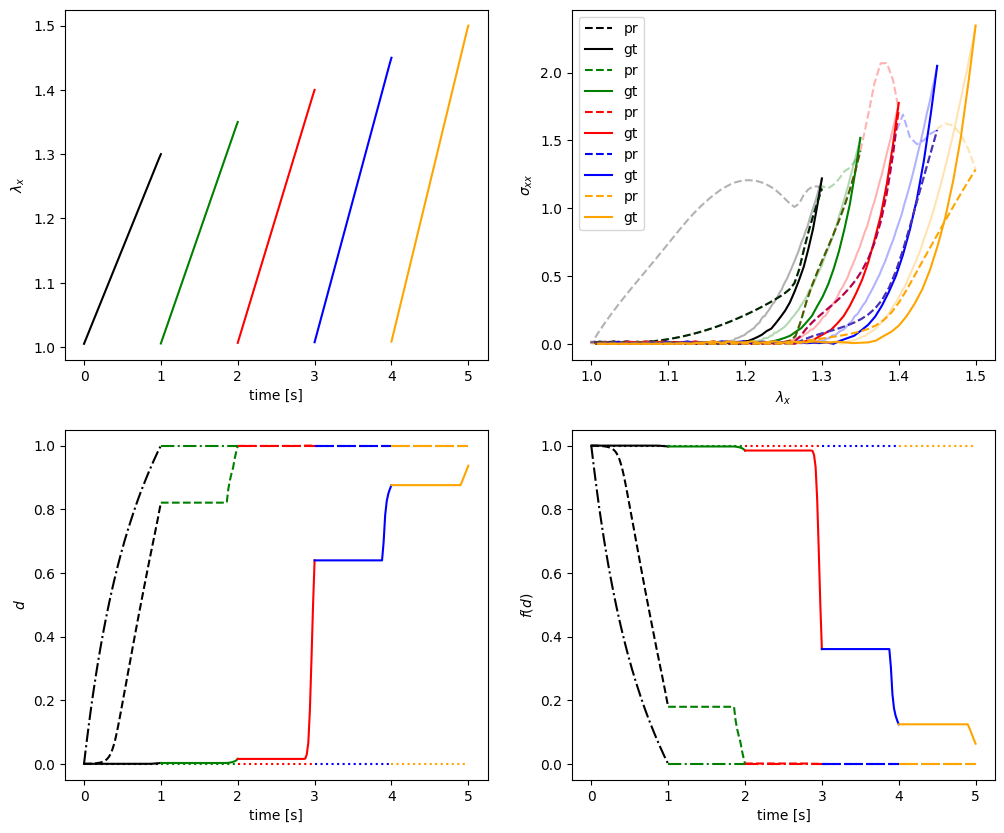

In [12]:
f_params = params[1]
d = repeat_uniax(params, lmbx_u_gt)
d = np.array(d)
d[:,:,:4] = np.clip(d[:,:,:4], a_min=0.0, a_max=1.0)
fig, ax = plt.subplots(2,2,figsize=(12,10))

cols = ['black', 'green', 'red', 'blue', 'orange']
lnstyles = ['solid', 'dashed', 'dotted', 'dashdot']

t0 = 0.0
for i in range(n_cycles):
    col = cols[i]
    di = d[i]
    time = t0 + np.linspace(0,1,di.shape[0])
    t0 += 1.0
    lmbx = lmbx_u_gt[i]
    lmby = 1.0/np.sqrt(lmbx)
    sgmx_u = sgmx_u_gt[i]
    sgmx_u_pr = eval_Cauchy_vmap2(lmbx, lmby, di[-1], params)

    for j in range(4):
        lns = lnstyles[j]
        ax[1,0].plot(time, di[:,j], col, linestyle=lns)
        ax[1,1].plot(time, f_vmap(di[:,j], f_params[j]), col, linestyle=lns)

    ax[0,0].plot(time, lmbx, col)
    ax[0,1].plot(lmbx, sgmx_u_pr[:,0,0], col, linestyle='dashed', label='pr')
    ax[0,1].plot(lmbx, sgmx_u, col, linestyle='solid', label='gt')

    # loading curves
    sgmx_l_pr = eval_Cauchy_vmap(lmbx, lmby, di, params)
    ax[0,1].plot(lmbx, sgmx_l_pr[:,0,0], col, linestyle='dashed', alpha=0.3)

    lmbx = lmbx_l_gt[i]
    lmby = 1.0/np.sqrt(lmbx)
    sgmx_l = sgmx_l_gt[i]
    ax[0,1].plot(lmbx, sgmx_l, col, linestyle='solid', alpha=0.3)

ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')
ax[0,1].legend()
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')

ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

[Text(0.5, 0, 'time [s]'), Text(0, 0.5, '$f(d)$')]

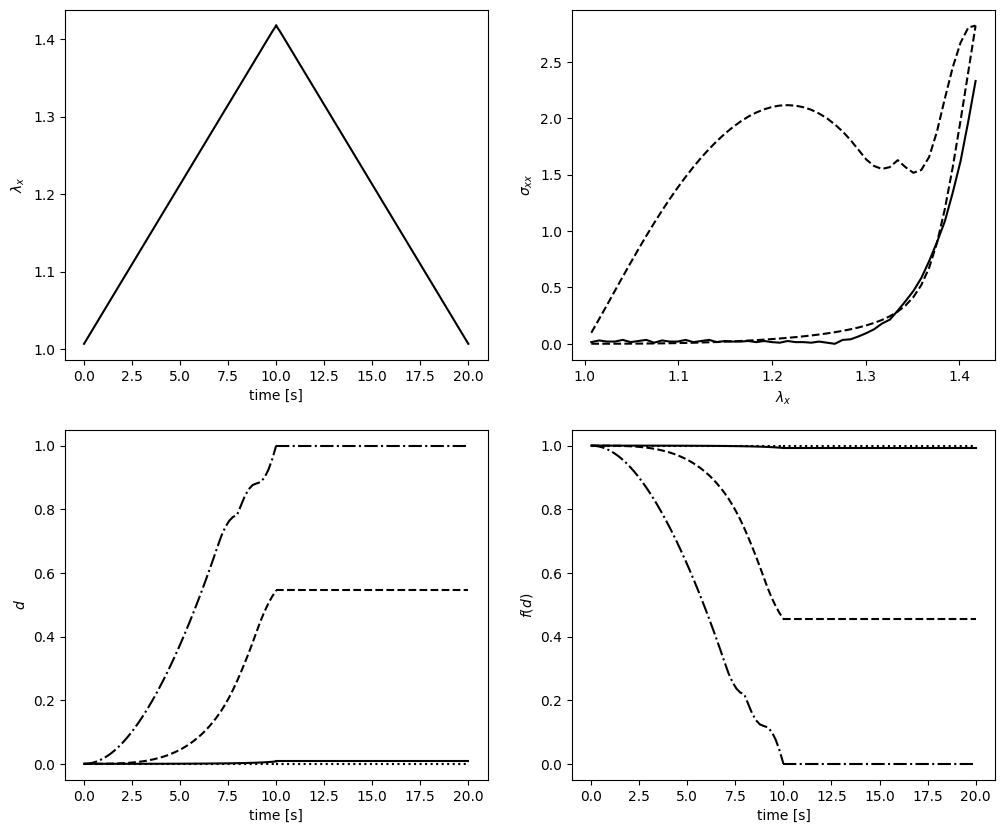

In [44]:
f_params = params[1]
d = repeat_uniax(params, lmbx_u_gt)
d = np.array(d)
d[:,:,:4] = np.clip(d[:,:,:4], a_min=0.0, a_max=1.0)
fig, ax = plt.subplots(2,2,figsize=(12,10))

cols = ['black', 'green', 'red', 'blue', 'orange']
lnstyles = ['solid', 'dashed', 'dotted', 'dashdot']

t0 = 0.0
for i in range(1):
    col = cols[i]
    di = d[i]
    lmbx = lmbx_u_gt[i]
    lmby = 1.0/np.sqrt(lmbx)
    sgmx = sgmx_u_gt[i]
    sgmx_pr_load = eval_Cauchy_vmap(lmbx, lmby, di, params)
    sgmx_pr_unload = eval_Cauchy_vmap2(lmbx, lmby, di[-1], params)

    time_load = np.linspace(t0, t0+10.0)
    time_unload = np.linspace(t0+10.0, t0+20.0)
    for j in range(n_damage):
        lns = lnstyles[j]
        ax[1,0].plot(time_load, di[:,j], col, linestyle=lns)
        ax[1,0].plot(time_unload, np.ones(50)*di[-1,j], col, linestyle=lns)
        f_vals = f_vmap(di[:,j], f_params[j])
        ax[1,1].plot(time_load, f_vals, col, linestyle=lns)
        ax[1,1].plot(time_unload, np.ones(50)*f_vals[-1], col, linestyle=lns)

    ax[0,0].plot(time_load, lmbx, col)
    ax[0,0].plot(time_unload, np.flip(lmbx), col)
    ax[0,1].plot(lmbx, sgmx_pr_load[:,0,0], col, linestyle='dashed', label='pr')
    ax[0,1].plot(lmbx, sgmx_pr_unload[:,0,0], col, linestyle='dashed', label='pr')
    ax[0,1].plot(lmbx, sgmx, col, linestyle='solid', label='gt')
    t0+= 20.0
ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')
# ax[0,1].legend()
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')

ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')